# Week 02
## Setup

In [1]:
library("rethinking")
data(Howell1)
d <- Howell1
d2 <- d[d$age >= 18, ]


Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

rethinking (Version 1.88)



## Exercise 2

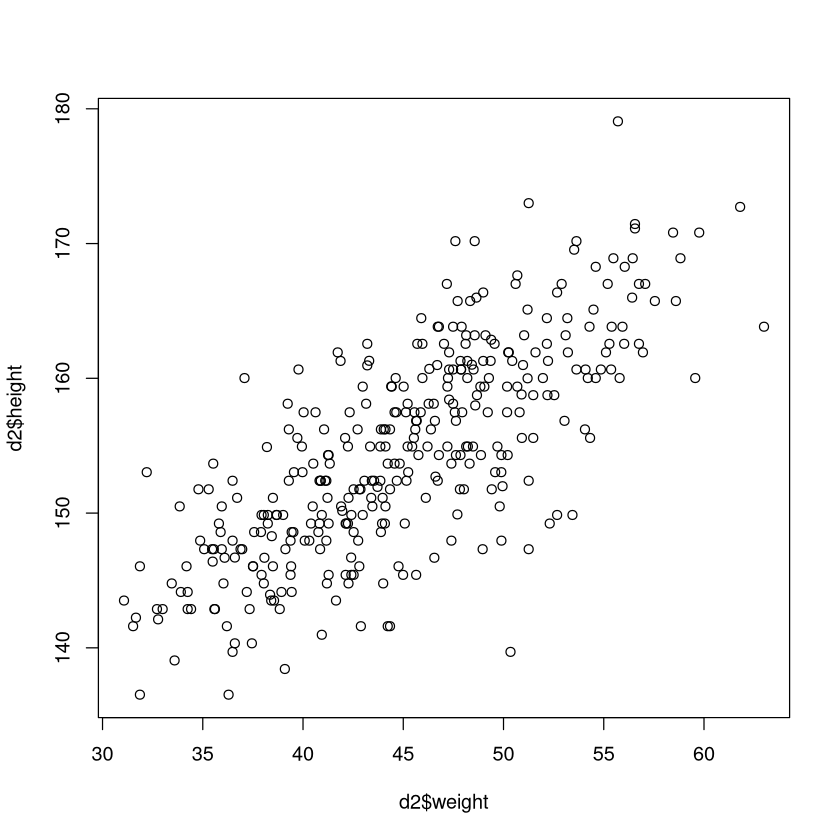

In [7]:
plot(d2$height ~ d2$weight)

In [ ]:
Define a linear model and predict the posterior with quap (quadratic approximation)

In [9]:
xbar <- mean(d2$weight)
m4.3 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * (weight - xbar),
        a ~ dnorm(178, 20),
        b ~ dlnorm(0, 1),
        sigma ~ dunif(0, 50)
    ), 
    data=d2)

We continue by simulating data according to our tabular values. We than calculate the mean and the 89% compatibility intervall for each entry.

In [20]:
dat <- data.frame(weight=c(45, 40, 65, 31, 53))
h_sim <- sim(m4.3, data=dat)
Eh <- apply(h_sim, 2, mean)
h_ci <- apply(h_sim, 2, PI, prob=0.89)

Include the predicted values inside the data frame dat and print the rounded table

In [22]:
dat$Eh <- Eh
dat$L89 <- h_ci[1,]
dat$U89 <- h_ci[2,]
round(dat, 1)

weight,Eh,L89,U89
<dbl>,<dbl>,<dbl>,<dbl>
45,154.5,146.5,162.6
40,149.5,141.3,157.7
65,172.7,164.3,181.5
31,141.9,133.8,150.4
53,161.7,153.5,169.4


## Exercise 2

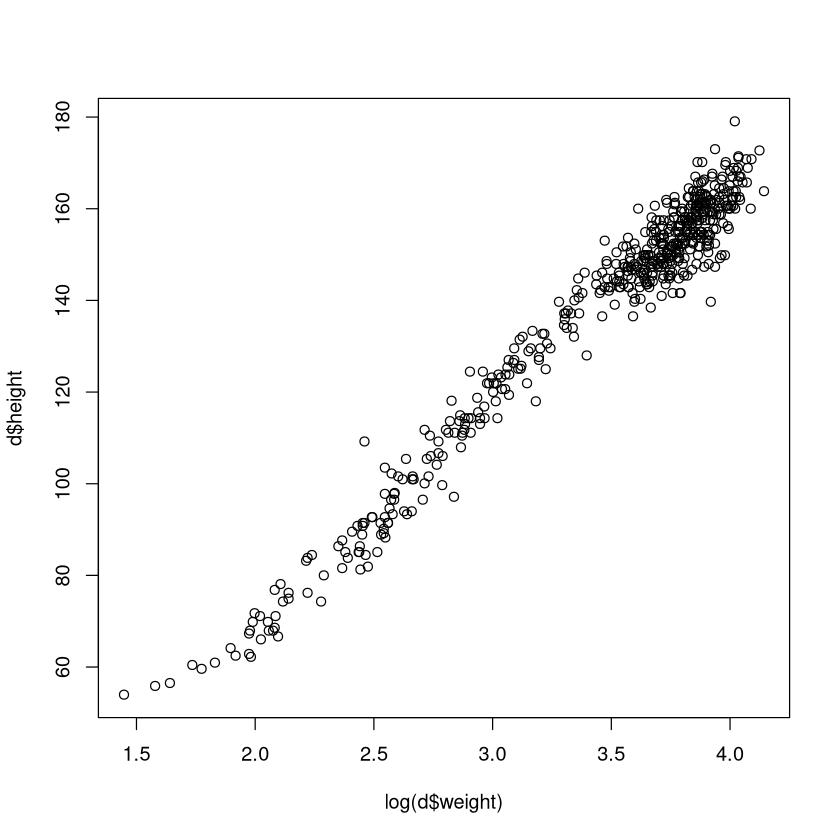

In [24]:
plot(d$height ~ log(d$weight))

The plot is pretty linear in that dimension, so we still use a linear model between height ~ log(weight). We than simulate data according to the distribution, calculated with our optimized model.

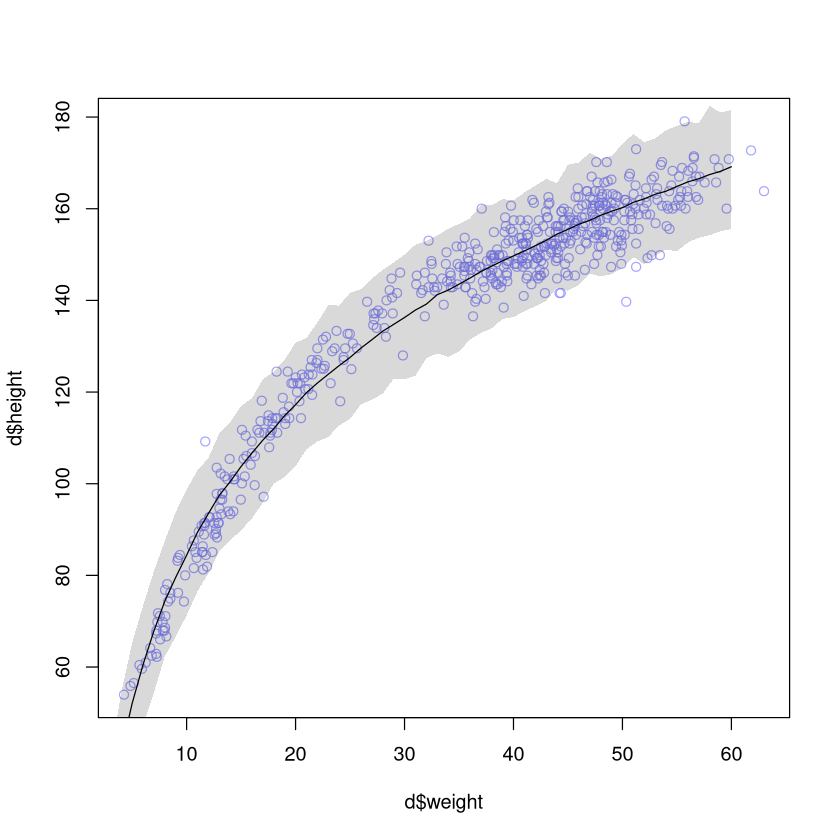

In [26]:
d$log_weight <- log(d$weight)
xbar <- mean(d$log_weight)

m2 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * (log_weight - xbar),
        a ~ dnorm(178, 20),
        b ~ dlnorm(0, 1),
        sigma ~ dunif(0, 50)
    ), 
    data=d)

plot( d$weight, d$height, col=col.alpha(rangi2, 0.7))
x_seq <- log(1:60)
mu <- sim(m2, data=list(log_weight=x_seq))
mu_mean <- apply(mu, 2, mean)
mu_ci <- apply(mu, 2, PI, 0.99)
lines(exp(x_seq), mu_mean)
shade(mu_ci, exp(x_seq))

A very poor approximation of the human body is that of a zylinder with a homogeneous mass density. 
$$ m \propto V$$
$$ V = h \pi r^2 $$
also for a human body, if the body gets taller the radius gets larger
$$ r \propto h$$
$$ V \propto h^3 $$
$$ m \propto h^3$$
So we build a polynom model for our height distributen

In [81]:
d$weight_s <- (d$weight - mean(d$weight))/sd(d$weight)
d$weight_s2 <- d$weight_s^2
d$weight_s3 <- d$weight_s^3

m2.2 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + b * weight_s + c * weight_s2 + d * weight_s3,
        a ~ dnorm(146, 20),
        b ~ dnorm(15, 15),
        c ~ dnorm(-6, 6),
        d ~ dnorm(3.5, 3),
        sigma ~ dunif(0, 50)
    ), 
    data=d)

set.seed(45)
prior <- extract.prior(m2.2)
precis(prior)

w_seq <- seq(from=min(d$weight_s), to=max(d$weight_s), length.out=50)
w_seq2 <- w_seq^2
w_seq3 <- w_seq^3

mu <- link(m2.2, post=prior, data=list(weight_s=w_seq, weight_s2=w_seq2, weight_s3=w_seq3))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
a,145.608672,20.724983,112.178506,179.421234,▁▁▂▅▇▃▁▁▁
b,15.117872,14.716521,-10.172636,37.337636,▁▁▂▇▇▇▃▁▁
c,-6.302212,5.812838,-15.853790,2.682724,▁▁▅▇▇▃▁▁
d,3.549909,2.955077,-1.128998,8.070231,▁▁▁▂▅▇▇▃▁▁▁▁
sigma,25.778804,14.271170,3.264064,47.253102,▅▇▅▇▇▇▇▇▇▇


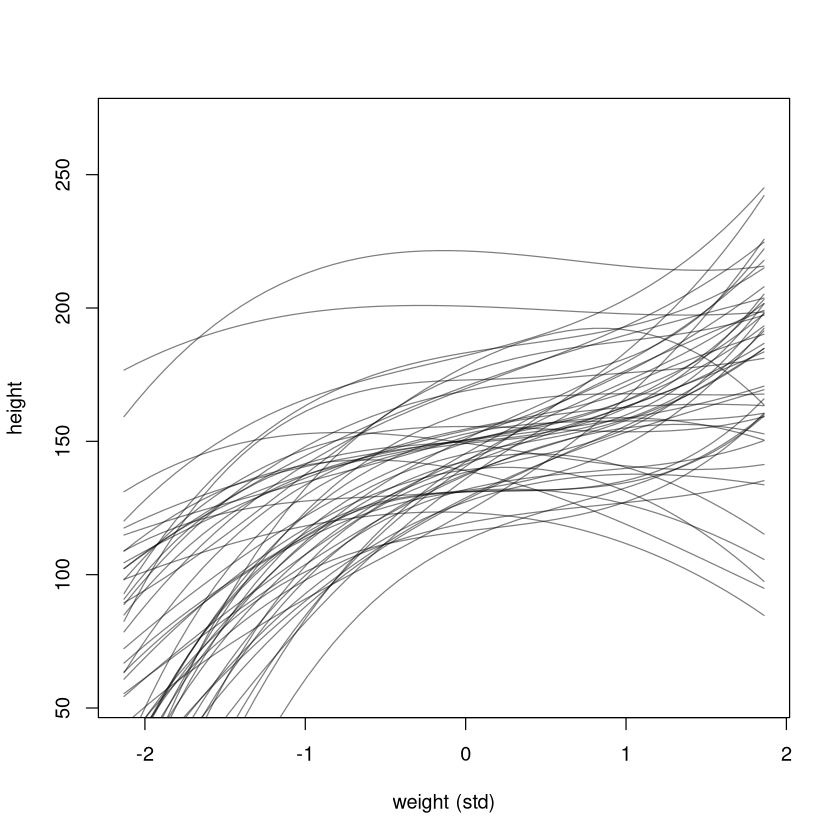

In [82]:
plot(NULL, xlim=range(w_seq), ylim=c(55,270),
    xlab="weight (std)", ylab="height")
for (i in 1:50) lines(w_seq, mu[i,], col=col.alpha("black", 0.5))

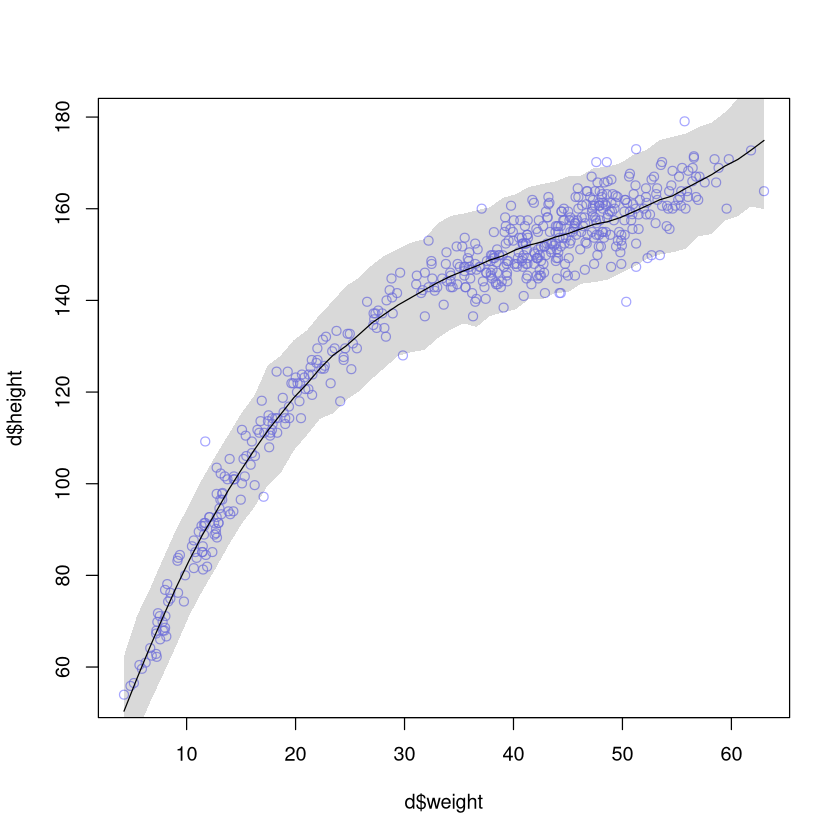

In [83]:
plot( d$weight, d$height, col=col.alpha(rangi2, 0.7))
mu <- sim(m2.2, data=list(weight_s=w_seq, weight_s2=w_seq2, weight_s3=w_seq3))
mu_mean <- apply(mu, 2, mean)
mu_ci <- apply(mu, 2, PI, 0.99)

m <- mean(d$weight)
std <- sd(d$weight)

lines(w_seq*std+m, mu_mean)
shade(mu_ci, w_seq*std+m)